## need to make cluster sites ordered

In [1]:
import pandas as pd
import numpy as np
import copy
from math import *
import os
import random
from collections import defaultdict
import csv
from functools import reduce
from copy import deepcopy
import pickle
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from ase import Atoms
from ase.io import read
from ase.io import write
from ase.visualize import view
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
def lattice_axes_xyz(lattice):
    '''
    function to prepare the xyz axes, which is a matrix as following:
                [ax] [ay] [az]
    axes_xyz =  [bx] [by] [bz]
                [cx] [cy] [cz]
    '''
    a = np.array([1,0,0]) * lattice['a']
    b = np.array([cos(lattice['gamma']/180*pi), sin(lattice['gamma']/180*pi), 0]) * lattice['b']
    c = np.cross(a, b)/np.linalg.norm(np.cross(a, b)) * lattice['c']
    return np.array((a,b,c))

In [4]:
def lattice_axes_abc(lattice):
    '''
    function to prepare the abc axes, which is a matrix as following:
                [ua] [ub] [uc]
    axes_abc =  [va] [vb] [vc]
                [wa] [wb] [wc]
    '''
    return np.array((lattice['u'], lattice['v'], lattice['w']))

In [5]:
def frac_to_xyz(axes_xyz, frac_coor):
    '''
    function to convert fractional coordinates to xyz coordinates
    '''
    return np.dot(frac_coor, axes_xyz)

In [6]:
def xyz_to_frac(axes_xyz, xyz_coor):
    '''
    function to convert xyz coordinates to fractional coordinates
    '''
    return np.dot(xyz_coor, np.linalg.inv(axes_xyz))

In [7]:
def frac_to_uvw(axes_abc, frac_coor):
    '''
    function to convert fractional(abc) coordinates to uvw coordinates
    '''
    return np.dot(frac_coor, np.linalg.inv(axes_abc))

In [8]:
def uvw_to_frac(axes_abc, uvw_coor):
    '''
    function to convert uvw coordinates to fractional(abc) coordinates
    '''
    return np.dot(uvw_coor, axes_abc)

In [9]:
def find_site_index_frac(frac, df):
    '''
    function to find site index from fractional coordinates
    '''
    site_index = list(df[(abs(df.a-frac[0]) < 0.001) & (abs(df.b-frac[1]) < 0.001) & (abs(df.c-frac[2]) < 0.001)].site_index)
    if len(site_index) == 0:
        print("Error! Cannot find the site index in the structure.")
        return np.nan
    elif len(site_index) < 1:
        print("Error! Find multiple site indices in the structure.")
        return np.nan
    else:
        return site_index[0]

In [10]:
def find_site_index_xyz(xyz, df):
    '''
    function to find site index from fractional coordinates
    '''
    site_index = list(df[(abs(df.x-xyz[0]) < 0.001) & (abs(df.y-xyz[1]) < 0.001) & (abs(df.z-xyz[2]) < 0.001)].site_index)
    #print(site_index)
    if len(site_index) == 0:
        print("Error! Cannot find the site index in the structure.")
        return np.nan
    elif len(site_index) > 1:
        print("Error! Find multiple site indices in the structure.")
        return np.nan
    else:
        return site_index[0]

In [11]:
def find_df_index_frac(frac, df):
    df_index = list(df[(abs(df.a-frac[0]) < 0.001) & (abs(df.b-frac[1]) < 0.001) & (abs(df.c-frac[2]) < 0.001)].index)
    if len(df_index) == 0:
        print("Error! Cannot find the site index in the structure.")
        return np.nan
    elif len(df_index) > 1:
        print("Error! Find multiple site indices in the structure.")
        return np.nan
    else:
        return int(df_index[0])   

In [12]:
def find_df_index_xyz(xyz, df):
    df_index = list(df[(abs(df.x-xyz[0]) < 0.001) & (abs(df.y-xyz[1]) < 0.001) & (abs(df.z-xyz[2]) < 0.001)].index)
    if len(df_index) == 0:
        print("Error! Cannot find the site index in the structure.")
        return np.nan
    elif len(df_index) > 1:
        print("Error! Find multiple site indices in the structure.")
        return np.nan
    else:
        return int(df_index[0])

In [13]:
def translate_frac_into_structure(frac_coor, axes_abc, structure):
    nu, nv, nw = len(urange),len(vrange),len(wrange)
    
    fu, fv, fw = np.dot(frac_coor, np.linalg.inv(axes_abc))
    print(fu, fv,fw)
    
    #translate the site into the structure by subtracting multiple structure vector on each dimension
    fu -= (fu//nu)*nu
    fv -= (fv//nv)*nv
    fw -= (fw//nw)*nw
    print(fu, fv, fw)
    
    return np.dot(np.array((fu, fv, fw)), axes_abc)

In [14]:
def add_xyz(df, axes_xyz):
    df['x'] = df.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[0], axis=1)
    df['y'] = df.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[1], axis=1)
    df['z'] = df.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[2], axis=1)
    return df

In [15]:
def visualize_str_no_rep(vis_sites_df, str_vec, xyz_file_path, png_file_path):
    filepath = xyz_file_path
    if os.path.isfile(filepath):
        os.remove(filepath)
    with open(filepath, 'a') as file:
        file.write('{}\n'.format(len(sites_df)))
        file.write('\n')
        for index, row in sites_df.iterrows():
            if row.atom in irrelevant_atom:
                file.write('{} {} {} {}\n'.format(row.atom,row.x, row.y, row.z))
            else:
                file.write('{} {} {} {}\n'.format(row.atom.split(',')[int(str_vec[index])],row.x, row.y, row.z))
    c= read(filepath)
    write(png_file_path, c, format=None, parallel=True)

In [16]:
def visualize_str_rep(sites_df, str_vec, xyz_file_path, png_file_path, irrelevant_atom=[]):
    filepath = xyz_file_path
    if os.path.isfile(filepath):
        os.remove(filepath)
    with open(filepath, 'a') as file:
        file.write('{}\n'.format(len(sites_df)))
        file.write('\n')
        for index, row in sites_df.iterrows():
            if row.atom in irrelevant_atom:
                file.write('{} {} {} {}\n'.format(row.atom,row.x, row.y, row.z))
            else:
                df_index = index%(len(str_vec))
                
                #print(index)
                #print(df_index)
                file.write('{} {} {} {}\n'.format(row.atom.split(',')[int(str_vec[df_index])],row.x, row.y, row.z))
    c= read(filepath)
    write(png_file_path, c, format=None, parallel=True)

#### Read lat.in

In [17]:
filepath='lat.in'
file = open(filepath, 'r')
lat = file.readlines()

lattice = {}
lattice['a'], lattice['b'], lattice['c'], lattice['alpha'], lattice['beta'], lattice['gamma'] = [float(number) for number in lat[0].split()]
lattice['u'] = [int(number) for number in lat[1].split()]
lattice['v'] = [int(number) for number in lat[2].split()]
lattice['w'] = [int(number) for number in lat[3].split()]

lattice_sites = pd.DataFrame(columns=['a', 'b', 'c', 'atom'])
for line in lat[4:]:
    site = line.split()[:3]
    atom_type = ''
    for atom in line.split()[3:]:
        atom_type += str(atom)
    site.append(atom_type)
    lattice_sites = lattice_sites.append(pd.DataFrame([site], columns=['a', 'b', 'c', 'atom']))
lattice_sites = lattice_sites.apply(pd.to_numeric, errors = 'ignore')
lattice_sites.reset_index(drop=True, inplace=True)
lattice['sites'] = lattice_sites

In [18]:
lattice

{'a': 13.675,
 'alpha': 90.0,
 'b': 13.675,
 'beta': 90.0,
 'c': 14.767,
 'gamma': 120.0,
 'sites':             a         b         c   atom
 0    0.666967  0.106933  0.228233  Si,Al
 1    0.893067  0.560033  0.228233  Si,Al
 2    0.666967  0.560033  0.228233  Si,Al
 3    0.439967  0.333033  0.228233  Si,Al
 4    0.568667  0.137333  0.456033      O
 5    0.235333  0.470667  0.789367      O
 6    0.098000  0.902000  0.877300      O
 7    0.764667  0.235333  0.210633      O
 8    0.431333  0.568667  0.543967      O
 9    0.098000  0.196000  0.877300      O
 10   0.902000  0.804000  0.122700      O
 11   0.431333  0.862667  0.543967      O
 12   0.804000  0.902000  0.877300      O
 13   0.470667  0.235333  0.210633      O
 14   0.137333  0.568667  0.543967      O
 15   0.196000  0.098000  0.122700      O
 16   0.862667  0.431333  0.456033      O
 17   0.529333  0.764667  0.789367      O
 18   0.235333  0.764667  0.789367      O
 19   0.568667  0.431333  0.456033      O
 20   0.764667  0.5

#### Run corrdump, generate clusters.out

In [19]:
!corrdump -2 = 6.2

Unable to open structure file


#### Read clusters.out

In [20]:
axes_abc = lattice_axes_abc(lattice)

In [21]:
axes_abc

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [22]:
frac_to_uvw(axes_abc, [1, 2, 1])

array([1., 2., 1.])

In [23]:
lat_clusters = {}

In [24]:
lat_clusters['type_num'] = [int(0) for i in range(10)]
lat_clusters['num_max_site'] = 0

In [25]:
lat_clusters['orig_file'] = []

with open('clusters.out') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=' ')
    for row in readCSV:
        if(len(row) == 0):
            continue
        elif(len(row) == 1):
            row[0] = row[0].replace('\t', '')
            lat_clusters['orig_file'].append(int(float(row[0])))
        else:
            temp = []
            for element in row:
                temp.append(float(element))
            lat_clusters['orig_file'].append(temp)

In [26]:
i = 0
nsite = 0
cluster_index = 0
urange = []
vrange = []
wrange = []

while(i < len(lat_clusters['orig_file'])):
    #print('i is {}'.format(i))
    m = lat_clusters['orig_file'][i]
    #print('m is {}'.format(m))
    d = lat_clusters['orig_file'][i+1]
    #print('d is {}'.format(d))
    new_nsite = lat_clusters['orig_file'][i+2]
    #print('new_site is {}'.format(new_nsite))
    if new_nsite != nsite:
        lat_clusters['num_max_site'] = new_nsite
        nsite = new_nsite
        cluster_index = 1
    else:
        cluster_index +=1
    
    cluster_type = '{}-{}'.format(nsite, cluster_index)
    lat_clusters[cluster_type] = {}
    lat_clusters[cluster_type]['m'] = m
    lat_clusters[cluster_type]['max_d'] = d
    lat_clusters[cluster_type]['eg_pair_frac']=[]
    
    i = i+3
    for j in range(nsite):
        site = lat_clusters['orig_file'][i][:3]
        u, v, w = frac_to_uvw(axes_abc, site)
        urange.append(u)
        vrange.append(v)
        wrange.append(w)
        #print(site)
        lat_clusters[cluster_type]['eg_pair_frac'].append(site)
        i += 1
    lat_clusters['type_num'][nsite] = cluster_index
lat_clusters['u_vis_range'] = list(range(int(min(urange))-1, int(max(urange))+1))
lat_clusters['v_vis_range'] = list(range(int(min(vrange))-1, int(max(vrange))+1))
lat_clusters['w_vis_range'] = list(range(int(min(wrange))-1, int(max(wrange))+1))

In [27]:
lat_clusters.keys()

dict_keys(['type_num', 'num_max_site', 'orig_file', '0-1', '1-1', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', 'u_vis_range', 'v_vis_range', 'w_vis_range'])

In [28]:
lat_clusters['u_vis_range']

[-1, 0, 1]

In [29]:
lat_vis_sites = pd.DataFrame(columns=lattice['sites'].columns)

In [30]:
for nu in lat_clusters['u_vis_range']:
    temp = deepcopy(lattice['sites'])
    temp.a = temp.a+nu*lattice['u'][0]
    temp.b = temp.b+nu*lattice['u'][1]
    temp.c = temp.c+nu*lattice['u'][2]
    lat_vis_sites = lat_vis_sites.append(temp)
prev_sites = deepcopy(lat_vis_sites)
for nv in lat_clusters['v_vis_range']:
    temp = deepcopy(prev_sites)
    temp.a = temp.a+nv*lattice['v'][0]
    temp.b = temp.b+nv*lattice['v'][1]
    temp.c = temp.c+nv*lattice['v'][2]
    lat_vis_sites = lat_vis_sites.append(temp)
prev_sites = deepcopy(lat_vis_sites)
for nw in lat_clusters['w_vis_range']:
    temp = deepcopy(prev_sites)
    temp.a = temp.a+nw*lattice['w'][0]
    temp.b = temp.b+nw*lattice['w'][1]
    temp.c = temp.c+nw*lattice['w'][2]
    lat_vis_sites = lat_vis_sites.append(temp)

In [31]:
lattice['sites'].head()

,a,b,c,atom
0,0.666967,0.106933,0.228233,"Si,Al"
1,0.893067,0.560033,0.228233,"Si,Al"
2,0.666967,0.560033,0.228233,"Si,Al"
3,0.439967,0.333033,0.228233,"Si,Al"
4,0.568667,0.137333,0.456033,O


In [32]:
lat_vis_sites.drop_duplicates(inplace=True)

In [33]:
lat_vis_sites.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1506 entries, 0 to 133
Data columns (total 4 columns):
a       1506 non-null float64
b       1506 non-null float64
c       1506 non-null float64
atom    1506 non-null object
dtypes: float64(3), object(1)
memory usage: 58.8+ KB


In [34]:
lattice.keys()

dict_keys(['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'u', 'v', 'w', 'sites'])

In [35]:
lattice_axes_xyz(lattice)

array([[13.675    ,  0.       ,  0.       ],
       [-6.8375   , 11.8428974,  0.       ],
       [ 0.       , -0.       , 14.767    ]])

In [36]:
lat_vis_sites = add_xyz(lat_vis_sites,lattice_axes_xyz(lattice))

In [37]:
lat_vis_sites['site_index'] = lat_vis_sites.groupby('atom').cumcount()
lat_vis_sites['new_site_index'] = lat_vis_sites.atom + '-' + lat_vis_sites.site_index.astype('str')
lat_vis_sites['site_index'] = lat_vis_sites['new_site_index']
lat_vis_sites.drop(['new_site_index'], axis = 1, inplace = True)

In [38]:
lat_clusters['lat_vis_sites'] = lat_vis_sites

In [39]:
!mkdir clusters
!mkdir clusters/xyzs
!mkdir clusters/images

In [40]:
filepath = 'clusters/xyzs/all_sites.xyz'
if os.path.isfile(filepath):
    os.remove(filepath)
with open(filepath, 'a') as file:
    file.write('{}\n'.format(len(lat_vis_sites)))
    file.write('\n')
    for index, row in lat_vis_sites.iterrows():
        file.write('{} {} {} {}\n'.format(row.atom.split(',')[0],row.x, row.y, row.z))

In [41]:
c= read('clusters/xyzs/all_sites.xyz')
#view(c)
write('clusters/images/all_sites.png', c, format=None, parallel=True)

In [42]:
lat_clusters.keys()

dict_keys(['type_num', 'num_max_site', 'orig_file', '0-1', '1-1', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', 'u_vis_range', 'v_vis_range', 'w_vis_range', 'lat_vis_sites'])

In [43]:
for i in range(1, int(lat_clusters['type_num'][2])+1):
    #print(i)
    indices = []
    sites = lat_clusters['2-{}'.format(i)]['eg_pair_frac']
    for site in sites:
        #print(site)
        index = find_site_index_frac(site, lat_vis_sites)
        indices.append(index)
    #print(indices)
    filepath = 'clusters/xyzs/cluster-2-{}.xyz'.format(i)
    if os.path.isfile(filepath):
        os.remove(filepath)
    with open(filepath, 'a') as file:
        file.write('{}\n'.format(len(lat_vis_sites)))
        file.write('\n')
        for index, row in lat_vis_sites.iterrows():
            if row.site_index in indices:
                file.write('{} {} {} {}\n'.format(row.atom.split(',')[1],row.x, row.y, row.z))
            else:
                file.write('{} {} {} {}\n'.format(row.atom.split(',')[0],row.x, row.y, row.z))
    c= read(filepath)
    #view(c)
    write('clusters/images/cluster-2-{}.png'.format(i), c, format=None, parallel=True)

#### read str_dim.txt

In [44]:
structure = {}

In [45]:
file = open('str_dim.txt', 'r')
str_req = file.readlines()

structure_u = [int(number) for number in str_req[0].split()]
structure_v = [int(number) for number in str_req[1].split()]
structure_w = [int(number) for number in str_req[2].split()]

In [46]:
l = int(np.mean(structure_u)/np.mean(lattice['u']))
m = int(np.mean(structure_v)/np.mean(lattice['v']))
n = int(np.mean(structure_w)/np.mean(lattice['w']))
ncell = l*m*n

In [47]:
structure['l'] = l
structure['m'] = m
structure['n'] = n
structure['u'] = structure_u
structure['v'] = structure_v
structure['w'] = structure_w
structure['ncell'] = ncell

In [48]:
str_sites = pd.DataFrame(columns=lattice['sites'].columns)

In [49]:
for nu in list(range(structure['l'])):
    temp = deepcopy(lattice['sites'])
    temp.a = temp.a+nu*lattice['u'][0]
    temp.b = temp.b+nu*lattice['u'][1]
    temp.c = temp.c+nu*lattice['u'][2]
    str_sites = str_sites.append(temp)
prev_sites = deepcopy(str_sites)
for nv in list(range(structure['m'])):
    temp = deepcopy(prev_sites)
    temp.a = temp.a+nv*lattice['v'][0]
    temp.b = temp.b+nv*lattice['v'][1]
    temp.c = temp.c+nv*lattice['v'][2]
    str_sites = str_sites.append(temp)
prev_sites = deepcopy(str_sites)
for nw in list(range(structure['n'])):
    temp = deepcopy(prev_sites)
    temp.a = temp.a+nw*lattice['w'][0]
    temp.b = temp.b+nw*lattice['w'][1]
    temp.c = temp.c+nw*lattice['w'][2]
    str_sites = str_sites.append(temp)

In [50]:
str_sites.drop_duplicates(inplace=True)

In [51]:
str_sites = add_xyz(str_sites,lattice_axes_xyz(lattice))

In [52]:
str_sites['site_index'] = str_sites.groupby('atom').cumcount()
str_sites['new_site_index'] = str_sites.atom + '-' + str_sites.site_index.astype('str')
str_sites['site_index'] = str_sites['new_site_index']
str_sites.drop(['new_site_index'], axis = 1, inplace = True)

In [53]:
str_sites.reset_index(drop=True, inplace=True)

In [54]:
structure['sites'] = str_sites

In [55]:
if os.path.isfile('str.out'):
    os.remove('str.out')
with open('str.out', 'a') as str_file:
    str_file.write('{} {} {} {} {} {}\n'.format(lattice['a'], lattice['b'], lattice['c'], int(lattice['alpha']), int(lattice['beta']), int(lattice['gamma'])))
    str_file.write('{} {} {}\n'.format(int(structure['u'][0]),int(structure['u'][1]),int(structure['u'][2])))
    str_file.write('{} {} {}\n'.format(int(structure['v'][0]),int(structure['v'][1]),int(structure['v'][2])))
    str_file.write('{} {} {}\n'.format(int(structure['w'][0]),int(structure['w'][1]),int(structure['w'][2])))
    for index, row in structure['sites'].iterrows():
        str_file.write('{} {} {} {}\n'.format(row.a, row.b, row.c, row.atom.split(',')[0]))

In [56]:
if os.path.isfile('cluster_list.csv'):
    os.remove('cluster_list.csv')
!corrdump -2 = 6.2 >> cluster_list.csv

In [57]:
structure.keys()

dict_keys(['l', 'm', 'n', 'u', 'v', 'w', 'ncell', 'sites'])

In [58]:
str_clusters = {}

In [59]:
clulist = []

with open('cluster_list.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=' ')
    for row in readCSV:
        if(len(row) == 0):
            continue
        elif(len(row) == 1):
            row[0] = row[0].replace('\t', '')
            clulist.append(int(float(row[0])))
        else:
            temp = []
            for element in row:
                temp.append(float(element))
            clulist.append(temp)
            
str_clusters['cluster_orig_list'] = clulist

In [60]:
axes_xyz = lattice_axes_xyz(lattice)

#### read cluster list

In [61]:
nsite_type_numbers = {}
cluster_types = []

i = 0
nsite = 0
cluster_index = 1
temp = []

urage = []
vrange = []
wrange = []

while(i < len(clulist)):
    #read n_site
    new_nsite = clulist[i]
    i += 1
    
    #pass first three lines where the cluster contains 0 site
    if (new_nsite == 0):
        i+=2
        continue
    
    #if the cluster has more sites than the previous cluster, reset nsite and cluster index
    if (new_nsite != nsite):
        nsite = new_nsite
        cluster_index = 1
        
    #set the cluster type = [nsite]-[order of the specific cluster in all nsite-clusters].
    cluster_type = str(nsite)+'-'+str(cluster_index)
    cluster_types.append(cluster_type)
    
    #initialize a empty set called temp 
    temp = []
        
    #read multiplicity
    multiplicity = clulist[i]
    i += 1
    
    #go through all the clusters
    n_cluster = int(multiplicity *structure['ncell'])
    
    for j in range(n_cluster):
        cluster = []
        for k in range(nsite):
            point = []
            for element in clulist[i]:
                point.append(float(element))
            #print(point)
            u, v, w = frac_to_uvw(axes_abc, xyz_to_frac(axes_xyz,point))
            
            #print(u,v,w)
            urange.append(u)
            vrange.append(v)
            wrange.append(w)
            cluster.append(point)
            i += 1
        temp.append(cluster)
    
    #pass the line with correlation
    i += 1 
    
    #put the set of clusters in dictionary of clusters
    str_clusters[cluster_type] = temp
    nsite_type_numbers[str(nsite)] = cluster_index
    
    #count cluster types
    cluster_index += 1   

#str_clusters

#str_clusters['cluster_types'] = cluster_types
#str_clusters['nsite_type_numbers'] = nsite_type_numbers

In [62]:
structure.keys()

dict_keys(['l', 'm', 'n', 'u', 'v', 'w', 'ncell', 'sites'])

In [63]:
str_clusters.keys()

dict_keys(['cluster_orig_list', '1-1', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11'])

In [64]:
str_clusters['l_vis_range'] = list(range(int((min(urange))//structure['l']), int(max(vrange)//structure['l']+1)))
str_clusters['m_vis_range'] = list(range(int((min(vrange))//structure['m']), int(max(vrange)//structure['m']+1)))
str_clusters['n_vis_range'] = list(range(int((min(wrange))//structure['n']), int(max(wrange)//structure['n']+1)))

In [65]:
str_clusters['l_vis_range'], str_clusters['m_vis_range'] ,str_clusters['n_vis_range']

([-1, 0, 1], [-1, 0, 1], [-1, 0, 1])

In [66]:
structure['w']

[0, 0, 1]

In [67]:
str_vis_sites = pd.DataFrame(columns=structure['sites'].columns)

for nu in str_clusters['l_vis_range']:
    temp = deepcopy(structure['sites'])
    temp.a = temp.a+nu*structure['u'][0]
    temp.b = temp.b+nu*structure['u'][1]
    temp.c = temp.c+nu*structure['u'][2]
    str_vis_sites = str_vis_sites.append(temp)
prev_sites = deepcopy(str_vis_sites)
for nv in str_clusters['m_vis_range']:
    temp = deepcopy(prev_sites)
    temp.a = temp.a+nv*structure['v'][0]
    temp.b = temp.b+nv*structure['v'][1]
    temp.c = temp.c+nv*structure['v'][2]
    str_vis_sites = str_vis_sites.append(temp)
prev_sites = deepcopy(str_vis_sites)
for nw in str_clusters['n_vis_range']:
    temp = deepcopy(prev_sites)
    temp.a = temp.a+nw*structure['w'][0]
    temp.b = temp.b+nw*structure['w'][1]
    temp.c = temp.c+nw*structure['w'][2]
    str_vis_sites = str_vis_sites.append(temp)

In [68]:
str_vis_sites.drop_duplicates(inplace=True)

In [69]:
str_vis_sites.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31266 entries, 0 to 1157
Data columns (total 8 columns):
a             31266 non-null float64
b             31266 non-null float64
c             31266 non-null float64
atom          31266 non-null object
x             31266 non-null float64
y             31266 non-null float64
z             31266 non-null float64
site_index    31266 non-null object
dtypes: float64(6), object(2)
memory usage: 2.1+ MB


In [70]:
str_vis_sites = add_xyz(str_vis_sites,axes_xyz)

In [71]:
str_clusters['str_vis_sites'] = str_vis_sites

In [72]:
!mkdir str_clusters_rep
!mkdir str_clusters_rep/xyzs
!mkdir str_clusters_rep/images

In [73]:
filepath = 'str_clusters_rep/xyzs/all_sites.xyz'
if os.path.isfile(filepath):
    os.remove(filepath)
with open(filepath, 'a') as file:
    file.write('{}\n'.format(len(str_vis_sites)))
    file.write('\n')
    for index, row in str_vis_sites.iterrows():
        file.write('{} {} {} {}\n'.format(row.atom.split(',')[0],row.x, row.y, row.z))
c= read('str_clusters_rep/xyzs/all_sites.xyz')
#view(c)
write('str_clusters_rep/images/all_sites.png', c, format=None, parallel=True)

In [74]:
view(c)

In [75]:
!mkdir str_clusters_no_rep
!mkdir str_clusters_no_rep/xyzs
!mkdir str_clusters_no_rep/images

In [76]:
filepath = 'str_clusters_no_rep/xyzs/all_sites.xyz'
if os.path.isfile(filepath):
    os.remove(filepath)
with open(filepath, 'a') as file:
    file.write('{}\n'.format(len(str_vis_sites)))
    file.write('\n')
    for index, row in str_vis_sites.iterrows():
        file.write('{} {} {} {}\n'.format(row.atom.split(',')[0],row.x, row.y, row.z))
c= read('str_clusters_no_rep/xyzs/all_sites.xyz')
#view(c)
write('str_clusters_no_rep/images/all_sites.png', c, format=None, parallel=True)

In [77]:
str_clusters.keys()

dict_keys(['cluster_orig_list', '1-1', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', 'l_vis_range', 'm_vis_range', 'n_vis_range', 'str_vis_sites'])

In [78]:
str_clusters['str_vis_sites'].reset_index(drop=True, inplace=True)

In [79]:
str_clusters['str_vis_sites'].head()

,a,b,c,atom,x,y,z,site_index
0,-2.333033,0.106933,0.228233,"Si,Al",-32.635381,1.266397,3.370317,"Si,Al-0"
1,-2.106933,0.560033,0.228233,"Si,Al",-32.641534,6.632413,3.370317,"Si,Al-1"
2,-2.333033,0.560033,0.228233,"Si,Al",-35.733452,6.632413,3.370317,"Si,Al-2"
3,-2.560033,0.333033,0.228233,"Si,Al",-37.285564,3.944076,3.370317,"Si,Al-3"
4,-2.431333,0.137333,0.456033,O,-34.187493,1.626421,6.734239,O-0


In [80]:
str_clusters['str_vis_sites'] = str_vis_sites

In [81]:
# k = 1
# for i in range(len(str_clusters['2-{}'.format(k)])):
#     #print(i)
#     str_vec_no_rep = [0 for i in range(len(str_clusters['str_vis_sites']))]
#     str_vec_rep = [0 for i in range(len(structure['sites']))]

#     sites = str_clusters['2-{}'.format(k)][i]
    
#     for site in sites:
#         site_index = find_site_index_xyz(site,str_clusters['str_vis_sites'])
#         site_index = int(site_index.split('-')[-1])
#         str_vec_rep[site_index] = 1
        
#         df_index = find_df_index_xyz(site,str_clusters['str_vis_sites'])
#         str_vec_no_rep[df_index] = 1
    
#     visualize_str_no_rep(str_clusters['str_vis_sites'], str_vec_no_rep, 'str_clusters_no_rep/xyzs/cluster-2-{}-{}.xyz'.format(k, i+1), 'str_clusters_no_rep/images/cluster-2-{}-{}.png'.format(k, i+1), ['O'])
    
#     visualize_str_rep(str_clusters['str_vis_sites'],str_vec_rep, 'str_clusters_rep/xyzs/cluster-2-{}-{}.xyz'.format(k, i+1), 'str_clusters_rep/images/cluster-2-{}-{}.png'.format(k, i+1),['O'])

In [83]:
lat_clusters['v_vis_range']

[-1, 0]

#### pair sites for structure sites

In [84]:
structure['sites'].head()

,a,b,c,atom,x,y,z,site_index
0,0.666967,0.106933,0.228233,"Si,Al",8.389619,1.266397,3.370317,"Si,Al-0"
1,0.893067,0.560033,0.228233,"Si,Al",8.383466,6.632413,3.370317,"Si,Al-1"
2,0.666967,0.560033,0.228233,"Si,Al",5.291548,6.632413,3.370317,"Si,Al-2"
3,0.439967,0.333033,0.228233,"Si,Al",3.739436,3.944076,3.370317,"Si,Al-3"
4,0.568667,0.137333,0.456033,O,6.837507,1.626421,6.734239,O-0


In [85]:
lat_clusters.keys()

dict_keys(['type_num', 'num_max_site', 'orig_file', '0-1', '1-1', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', 'u_vis_range', 'v_vis_range', 'w_vis_range', 'lat_vis_sites'])

In [86]:
str_clusters.keys()

dict_keys(['cluster_orig_list', '1-1', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', 'l_vis_range', 'm_vis_range', 'n_vis_range', 'str_vis_sites'])

In [87]:
str_clusters['type_num'] = lat_clusters['type_num']

In [88]:
#create one column for each cluster type
for nsite, ncluster in enumerate(str_clusters['type_num']):
    if nsite == 0:
        continue
    #print(nsite, ncluster)
    for index in range(1, int(ncluster)+1):
        #print(index)
        clu_type = str(nsite)+'-'+str(int(index))
        structure['sites'][clu_type] = ""
        structure['sites'][clu_type].astype('str')

In [89]:
structure['sites'].head()

,a,b,c,atom,x,y,z,site_index,1-1,2-1,2-2,2-3,2-4,2-5,2-6,2-7,2-8,2-9,2-10,2-11
0,0.666967,0.106933,0.228233,"Si,Al",8.389619,1.266397,3.370317,"Si,Al-0",,,,,,,,,,,,
1,0.893067,0.560033,0.228233,"Si,Al",8.383466,6.632413,3.370317,"Si,Al-1",,,,,,,,,,,,
2,0.666967,0.560033,0.228233,"Si,Al",5.291548,6.632413,3.370317,"Si,Al-2",,,,,,,,,,,,
3,0.439967,0.333033,0.228233,"Si,Al",3.739436,3.944076,3.370317,"Si,Al-3",,,,,,,,,,,,
4,0.568667,0.137333,0.456033,O,6.837507,1.626421,6.734239,O-0,,,,,,,,,,,,


In [90]:
lattice.keys()

dict_keys(['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'u', 'v', 'w', 'sites'])

In [91]:
lat_clusters.keys()

dict_keys(['type_num', 'num_max_site', 'orig_file', '0-1', '1-1', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', 'u_vis_range', 'v_vis_range', 'w_vis_range', 'lat_vis_sites'])

In [92]:
str_clusters.keys()

dict_keys(['cluster_orig_list', '1-1', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', 'l_vis_range', 'm_vis_range', 'n_vis_range', 'str_vis_sites', 'type_num'])

In [93]:
i = 0
nsite = 0
cluster_index = 1
temp = []
urage = []
vrange = []
wrange = []

while(i < len(clulist)):
    #read n_site
    new_nsite = clulist[i]
    i += 1
    
    #pass first three lines where the cluster contains 0 site
    if (new_nsite == 0):
        i+=2
        continue
    
    #if the cluster has more sites than the previous cluster, reset nsite and cluster index
    if (new_nsite != nsite):
        nsite = new_nsite
        cluster_index = 1
        
    #set the cluster type = [nsite]-[order of the specific cluster in all nsite-clusters].
    cluster_type = str(nsite)+'-'+str(cluster_index)
    cluster_types.append(cluster_type)
    
    #initialize a empty set called temp 
    temp = []
        
    #read multiplicity
    multiplicity = clulist[i]
    i += 1
    
    #go through all the clusters
    n_cluster = int(multiplicity *structure['ncell'])
    
    for j in range(n_cluster):
        cluster = []
        for k in range(nsite):
            point = []
            for element in clulist[i]:
                point.append(float(element))
            site = find_site_index_xyz(point, str_vis_sites)
            #print(u,v,w)
            cluster.append(site)
            i += 1
        temp.append(cluster)
    
    #pass the line with correlation
    i += 1 
    
    #put the set of clusters in dictionary of clusters
    str_clusters[cluster_type+'indices'] = temp
    
    #count cluster types
    cluster_index += 1   

In [94]:
str_clusters['type_num']

[1, 1, 11, 0, 0, 0, 0, 0, 0, 0]

In [95]:
structure['sites'].reset_index(inplace=True, drop=True)

In [96]:
def find_df_index_from_site_index(df, site_index):
    return df[df['site_index'] == site_index].index[0]

In [97]:
for nsite, cluster_index in enumerate(str_clusters['type_num']):
    if nsite == 0:
        continue
    for index in range(1, cluster_index+1):
        clu_type = str(nsite)+'-'+str(index)
        for sites in str_clusters[clu_type+'indices']:
            #print(sites)
            for i, site in enumerate(sites):
                #print(site)
                site_index = int(site.split('-')[-1])
                df_index = find_df_index_from_site_index(structure['sites'], site)
                sites_res = deepcopy(sites[:i])
                sites_res.extend(deepcopy(sites[i+1:]))
                if (structure['sites'].iloc[df_index][clu_type] == ''):
                    structure['sites'].set_value(df_index, clu_type, set([frozenset(set(sites_res))]))
                else:
                    structure['sites'].iloc[df_index][clu_type].update([frozenset(set(sites_res))])

In [98]:
no_coexit_type = ['2-1','2-2','2-3','2-4']

In [99]:
!mkdir random_configuration
!mkdir random_configuration/xyzs
!mkdir random_configuration/images

In [100]:
atom_num = 12

In [101]:
available_sites = set([frozenset([x]) for x in list(structure['sites'][structure['sites']['atom'] == 'Si,Al'].site_index)])

structure_vector = [0 for i in range(len(structure['sites'].site_index))]

selected_sites = []
atom_count = 0

#visualize_str_rep(structure['sites'], structure_vector, 'random_configuration/xyzs/{}.xyz'.format(atom_count),'random_configuration/images/{}.png'.format(atom_count))

while((atom_count < atom_num) & (len(available_sites) > 0)):
    #random select one site from all the available sites
    site = random.sample(available_sites, 1)[0]
    site_index = list(site)[0]
    #print(site_index)
    
    #add selected site to the list
    selected_sites.append(int(site_index.split('-')[-1]))
    df_index = find_df_index_from_site_index(structure['sites'], site_index)
    structure_vector[df_index] = 1
    
    #find out the  sites for the selected site
    #print(site)
    no_coexist_sites = set()
    for t in no_coexit_type:
        no_coexist_sites.update([set(x) for x in list(list(structure['sites'][structure['sites']['site_index'] == site_index][t]))][0])
    #print(no_coexist_sites)
    
    #remove the selected site and the coresponding bad sites from available sites
    available_sites.remove(site)
    available_sites = available_sites.difference(no_coexist_sites)
    #print(available_sites)
    
    atom_count += 1
    
    visualize_str_rep(structure['sites'], structure_vector, 'random_configuration/xyzs/{}.xyz'.format(atom_count),'random_configuration/images/{}.png'.format(atom_count),['O'])

    
if(len(selected_sites) == atom_num):
    print(selected_sites)
else:
    print('Failed')


[51, 135, 202, 156, 295, 177, 237, 291, 232, 39, 7, 293]


In [102]:
structure['sites'].iloc[107]

a                                 0.0003
b                                 0.2267
c                                 0.8949
atom                               Si,Al
x                               -1.54596
y                                2.68478
z                                 13.215
site_index                       Si,Al-9
1-1                                 {()}
2-1                         {(Si,Al-15)}
2-2                         {(Si,Al-97)}
2-3                        {(Si,Al-312)}
2-4                         {(Si,Al-23)}
2-5             {(Si,Al-33), (Si,Al-90)}
2-6                          {(Si,Al-5)}
2-7           {(Si,Al-228), (Si,Al-315)}
2-8             {(Si,Al-85), (Si,Al-29)}
2-9            {(Si,Al-323), (Si,Al-20)}
2-10                        {(Si,Al-30)}
2-11                       {(Si,Al-222)}
Name: 107, dtype: object

In [103]:
visualize_str_rep(structure['sites'], structure_vector, 'random_configuration/xyzs/12.xyz'.format(atom_count),'random_configuration/images/12.png'.format(atom_count),['O'])

In [104]:
c = read('random_configuration/xyzs/{}.xyz'.format(12))
view(c)

In [105]:
!mkdir random_configuration_no_rules
!mkdir random_configuration_no_rules/xyzs
!mkdir random_configuration_no_rules/images

In [106]:
atom_num = 36

In [107]:
#no rules
available_sites = set([frozenset([x]) for x in list(structure['sites'][structure['sites']['atom'] == 'Si,Al'].site_index)])

structure_vector = [0 for i in range(len(structure['sites'].site_index))]

selected_sites = []
atom_count = 0

#visualize_str_rep(structure['sites'], structure_vector, 'random_configuration_no_rules/xyzs/{}.xyz'.format(atom_count),'random_configuration_no_rules/images/{}.png'.format(atom_count))

while((atom_count < atom_num) & (len(available_sites) > 0)):
    #random select one site from all the available sites
    site = random.sample(available_sites, 1)[0]
    site_index = list(site)[0]
    #print(site_index)
    
    #add selected site to the list
    selected_sites.append(int(site_index.split('-')[-1]))
    df_index = find_df_index_from_site_index(structure['sites'], site_index)
    structure_vector[df_index] = 1
    
    #remove the selected site and the coresponding bad sites from available sites
    available_sites.remove(site)
    #print(available_sites)
    
    atom_count += 1
    
    #visualize_str_rep(structure['sites'], structure_vector, 'random_configuration_no_rules/xyzs/{}.xyz'.format(atom_count),'random_configuration_no_rules/images/{}.png'.format(atom_count),['O'])
    
if(len(selected_sites) == atom_num):
    print(selected_sites)
else:
    print('Failed')


[200, 279, 75, 184, 242, 96, 105, 225, 152, 86, 191, 65, 111, 123, 313, 174, 50, 119, 257, 98, 260, 180, 148, 144, 259, 80, 87, 53, 204, 287, 209, 32, 85, 115, 309, 301]


In [108]:
np.sum(structure_vector)

36

#### count clusters

In [109]:
counting_types = ['2-7','2-11']

In [110]:
counting_results = defaultdict(int)
for clutype in counting_types:
    count = 0
    for cluster in str_clusters[clutype+'indices']:
        #print(cluster)
        exist = 1
        for site in cluster:
            df_index = find_df_index_from_site_index(structure['sites'], site)
            #print(df_index)
            if structure_vector[df_index] == 0:
                exist = 0
                continue
        if exist == 1:
            count+=1
        #print(count)
    counting_results[clutype] = count

In [111]:
counting_results

defaultdict(int, {'2-11': 4, '2-7': 6})

In [112]:
filepath = 'random_configuration/xyzs/12.xyz'
c = read(filepath)
#view(c)

In [113]:
y = [x/12 for x in counting_results.values()]

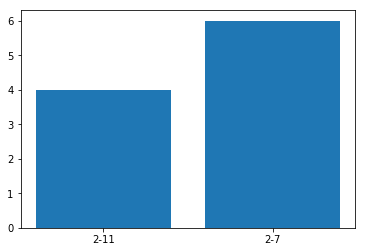

In [114]:
plt.bar(counting_results.keys(), counting_results.values());

In [115]:
all_site_count = {}
all_site_count['2-1'] = 24
all_site_count['2-2'] = 24
all_site_count['2-3'] = 24
all_site_count['2-4'] = 48
all_site_count['2-5'] = 24
all_site_count['2-6'] = 24

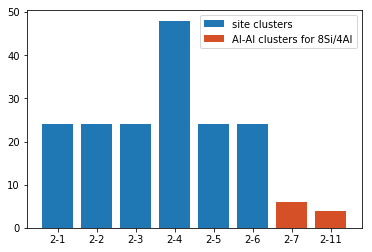

In [116]:
plt.bar(all_site_count.keys(), all_site_count.values(), label='site clusters')
plt.bar(counting_results.keys(), counting_results.values(), label='Al-Al clusters for 8Si/4Al',color='#D65027')
plt.legend();

In [117]:
def random_config(sites_df, atom_num, no_coexit_type=[]):
    fail= True
    while fail:
        available_sites = set([frozenset([x]) for x in list(structure['sites'][structure['sites']['atom'] == 'Si,Al'].site_index)])

        structure_vector = [0 for i in range(len(sites_df.site_index))]

        selected_sites = []
        atom_count = 0

        #visualize_str_rep(structure['sites'], structure_vector, 'random_configuration/xyzs/{}.xyz'.format(atom_count),'random_configuration/images/{}.png'.format(atom_count))

        while((atom_count < atom_num) & (len(available_sites) > 0)):
            #random select one site from all the available sites
            site = random.sample(available_sites, 1)[0]
            site_index = list(site)[0]
            #print(site_index)

            #add selected site to the list
            selected_sites.append(int(site_index.split('-')[-1]))
            df_index = find_df_index_from_site_index(structure['sites'], site_index)
            structure_vector[df_index] = 1

            #find out the  sites for the selected site
            #print(site)
            no_coexist_sites = set()
            for t in no_coexit_type:
                no_coexist_sites.update([set(x) for x in list(list(sites_df[sites_df['site_index'] == site_index][t]))][0])
            #print(no_coexist_sites)

            #remove the selected site and the coresponding bad sites from available sites
            available_sites.remove(site)
            available_sites = available_sites.difference(no_coexist_sites)
            #print(available_sites)

            atom_count += 1

            #visualize_str_rep(structure['sites'], structure_vector, 'random_configuration/xyzs/{}.xyz'.format(atom_count),'random_configuration/images/{}.png'.format(atom_count))

        if(len(selected_sites) == atom_num):
            fail=False

    return structure_vector


In [118]:
def count_clusters_structure(structure_vector, structure, str_clusters, counting_types):
    counting_results = defaultdict(int)
    for clutype in counting_types:
        count = 0
        for cluster in str_clusters[clutype+'indices']:
            exist = 1
            for site in cluster:
                df_index = find_df_index_from_site_index(structure['sites'], site)
                if structure_vector[df_index] == 0:
                    exist = 0
                    break
            if exist == 1:
                count+=1
        counting_results[clutype] = count
    return counting_results

In [119]:
def sum_two_dict(d1, d2):
    d = defaultdict(int)
    for key in list(set(d1.keys()).union(set(d2.keys()))):
        d[key] = d1[key] + d2[key]
    return d 

In [120]:
def div_dict(d, n):
    dnew = defaultdict(float)
    for key in d.keys():
        dnew[key] = d[key]/n
    return dnew

In [143]:
def count_clusters_composition(sites_df, atom_ratio, str_clusters, counting_types,repeat_num, no_coexit_type=[]):
    atom_num = int(atom_ratio * len(sites_df[sites_df.atom == 'Si,Al'].index))
    counting_results = defaultdict(int)
    for i in range(repeat_num):
        #print(i)
        str_vec = random_config(sites_df, atom_num, no_coexit_type)
        #print(str_vec)
        d1 = count_clusters_structure(str_vec, structure, str_clusters, counting_types)
        #print(d1)
        counting_results = sum_two_dict(counting_results, d1)
        #print(counting_results)
    counting_results= div_dict(counting_results, repeat_num)
    counting_results= div_dict(counting_results, atom_num)
    return counting_results

In [144]:
counting_types = ['2-1','2-2','2-3','2-4', '2-5','2-6','2-7','2-8','2-9', '2-10','2-11']

In [145]:
d1 = count_clusters_composition(structure['sites'], 1, str_clusters, counting_types,1, no_coexit_type=[])

In [146]:
d1

defaultdict(float,
            {'2-1': 0.5,
             '2-10': 0.5,
             '2-11': 0.5,
             '2-2': 0.5,
             '2-3': 0.5,
             '2-4': 0.5,
             '2-5': 1.0,
             '2-6': 0.5,
             '2-7': 1.0,
             '2-8': 1.0,
             '2-9': 1.0})

In [147]:
d3 = count_clusters_composition(structure['sites'], 1/3, str_clusters, counting_types,1000)

In [148]:
d3

defaultdict(float,
            {'2-1': 0.15555555555555556,
             '2-10': 0.17777777777777778,
             '2-11': 0.16018518518518518,
             '2-2': 0.16574074074074072,
             '2-3': 0.15462962962962962,
             '2-4': 0.175,
             '2-5': 0.3333333333333333,
             '2-6': 0.16203703703703703,
             '2-7': 0.32962962962962966,
             '2-8': 0.31574074074074077,
             '2-9': 0.3305555555555556})

In [149]:
d2 = count_clusters_composition(structure['sites'], 1/3, str_clusters, counting_types,1000, no_coexit_type=['2-1','2-2','2-3','2-4'])

In [150]:
d2

defaultdict(float,
            {'2-1': 0.0,
             '2-10': 0.1111111111111111,
             '2-11': 0.1259259259259259,
             '2-2': 0.0,
             '2-3': 0.0,
             '2-4': 0.0,
             '2-5': 0.5611111111111111,
             '2-6': 0.27499999999999997,
             '2-7': 0.46296296296296297,
             '2-8': 0.4083333333333333,
             '2-9': 0.4305555555555556})

In [151]:
counting_types

['2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11']

In [179]:
def plot_counts(counting_types, values, ylabel='count/site', label='', color='#D65027'):
    fig_w = 0.5*len(counting_types)
    value_series = pd.Series.from_array(values)   
    x_labels = counting_types

    # now to plot the figure...
    plt.figure(figsize=(fig_w, 5))
    ax = value_series.plot(kind='bar', color = color)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(x_labels)
    
    ax.legend([label])

    rects = ax.patches

    # Now make some labels
    labels = ['{:.2f}'.format(x) for x in values]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')

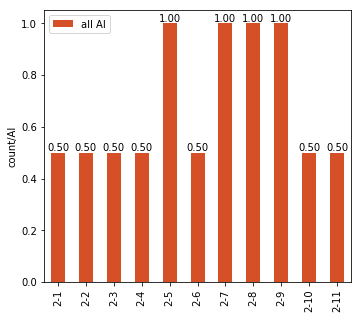

In [273]:
values = [d1[t] for t in counting_types]
plot_counts(counting_types, values, label='all Al', ylabel='count/Al')

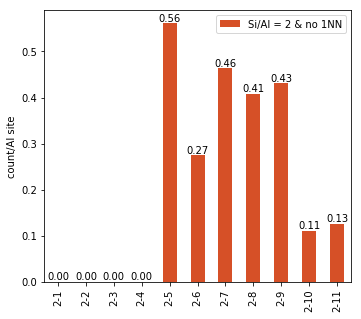

In [180]:
values = [d2[t] for t in counting_types]
plot_counts(counting_types, values, ylabel='count/Al site',label='Si/Al = 2 & no 1NN')

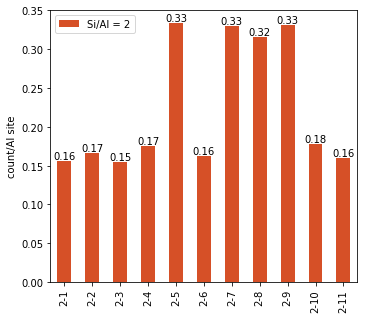

In [181]:
values = [d3[t] for t in counting_types]
plot_counts(counting_types, values, ylabel='count/Al site', label='Si/Al = 2')

#### titrate

In [318]:
def titrate_config_one_cluster(structure_vector,structure_sites, str_clusters, cluster_type, repeat_num):
    count = 0
    atom_count = np.sum(structure_vector)
    #print(repeat_num)
    for i in range(repeat_num):
        exist_clusters = []
        selected_clusters = []
        for cluster in str_clusters[cluster_type+'indices']:
            exist = 1
            for site in cluster:
                df_index = find_df_index_from_site_index(structure_sites, site)
                if structure_vector[df_index] == 0:
                    exist = 0
                    break
            if exist == 1:
                exist_clusters.append(cluster)
        while(exist_clusters):
            cluster = random.sample(exist_clusters, 1)[0]
            #print(cluster)

            #add selected clusters to list
            selected_clusters.append(cluster)
            #print(cluster)
            #remove selected clusters from the clusters of interest
            exist_clusters.remove(cluster)

            #remove other clusters that share elements with the selected cluster
            for site in cluster:
                #print(site)
                site_index = int(site.split('-')[-1])
                df_index = find_df_index_from_site_index(structure_sites, site)
                structure_vector[df_index] = 0
                for pair_site in structure_sites.iloc[df_index][cluster_type]:
                    relevant_cluster_1 = [site, list(pair_site)[0]]
                    relevant_cluster_2 = [list(pair_site)[0],site]
                    if relevant_cluster_1 in exist_clusters:
                        exist_clusters.remove(relevant_cluster_1)
                    if relevant_cluster_2 in exist_clusters:
                        exist_clusters.remove(relevant_cluster_2)
            #print(exist_clusters)
        count+=len(selected_clusters)
    count /= repeat_num
    return count, structure_vector

In [324]:
def titrate_config_multi_clusters(structure_vector,structure_sites, str_clusters, cluster_types, repeat_num):
    count = [0 for t in cluster_types]
    for n in range(repeat_num):
        str_vec = deepcopy(structure_vector)
        for i, cluster_type in enumerate(cluster_types):
            #print(np.sum(str_vec))
            #print(cluster_type)
            count_add, str_vec = titrate_config_one_cluster(str_vec,structure_sites, str_clusters, cluster_type, 1)
            #print(count_add)
            count[i] += count_add
    count = [c/repeat_num for c in count]
    return count

In [320]:
structure_vector = random_config(structure['sites'], 36, no_coexit_type)

In [323]:
def titrate_composition(sites_df, atom_ratio, str_clusters, titrate_cluster_types, config_repeat_num, titrate_repeat_num,no_coexit_type=[]):
    atom_num = int(atom_ratio * len(sites_df[sites_df.atom == 'Si,Al'].index))
    count = [0 for t in titrate_cluster_types]
    
    for i in range(config_repeat_num):
        #print(i)
        str_vec = random_config(sites_df, atom_num, no_coexit_type)
        #print(str_vec)
        count_add = titrate_config_multi_clusters(str_vec,sites_df, str_clusters, titrate_cluster_types, titrate_repeat_num)
        #print(count_add)
        #print(count)
        count = [(count[i]+count_add[i]) for i in range(len(count))]
    count = [c/config_repeat_num for c in count]
    return count

In [328]:
titrate_composition(structure['sites'], 0.3, str_clusters, ['2-7','2-11'], 10, 10, no_coexit_type=['2-1','2-2','2-3','2-4'])

[23.3, 15.0]

In [334]:
results = [23.3, 15]
titrate_count_per_Al = [result/0.3/len(structure['sites'][structure['sites'].atom == 'Si,Al'].index) for result in results]
titrate_count_per_Al

[0.23971193415637862, 0.15432098765432098]

In [262]:
Si_Al_ratios = [2.5, 5, 7.5, 10, 15, 20, 25, 30, 35, 40]
Al_ratios = [1/(1+x) for x in Si_Al_ratios]
Al_nums = [int(Al_ratio*len(structure['sites'][structure['sites'].atom == 'Si,Al'].index)) for Al_ratio in Al_ratios]
titrate_results = []

In [263]:
Al_nums

[92, 54, 38, 29, 20, 15, 12, 10, 9, 7]

In [280]:
for index, Al_ratio in enumerate(Al_ratios):
    print(index)
    t = titrate_composition(structure['sites'], Al_ratio, str_clusters, ['2-7','2-11'], 10, 10, no_coexit_type=['2-1','2-2','2-3','2-4'])
    print(t)
    titrate_results.append(t)

0
[0.23695652173913043, 0.27533833967402316]
1
[0.1796296296296296, 0.09116497881203764]
2
[0.12894736842105262, 0.05287878787878788]
3
[0.09310344827586207, 0.058890026999866806]
4
[0.049999999999999996, 0.02291666666666667]
5
[0.06666666666666667, 0.03982905982905983]
6
[0.05, 0.0]
7
[0.039999999999999994, 0.03]
8
[0.0, 0.011111111111111113]
9
[0.028571428571428564, 0.014285714285714282]


In [281]:
values = [titrate_results[i][0]+titrate_results[i][1] for i in range(10)]

In [282]:
values

[0.3042669244811601,
 0.21643013116764628,
 0.13055064130915522,
 0.1319820724558356,
 0.05055555555555555,
 0.523911545167266,
 0.3218327941838004,
 0.2210509775312407,
 0.12819109075370422,
 0.11547619047619048]

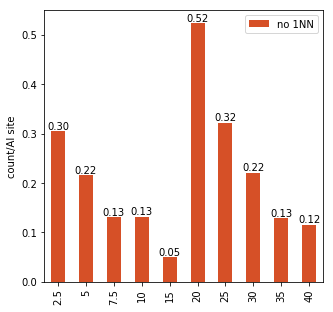

In [283]:
plot_counts(Si_Al_ratios, values, ylabel='count/Al site', label='no 1NN')

In [271]:
titrate_results_no_rules =[]
for index, Al_ratio in enumerate(Al_ratios):
    print(index)
    t = titrate_composition(structure['sites'], Al_ratio, str_clusters, ['2-7','2-11'], 10, 10, no_coexit_type=[])
    print(t)
    titrate_results_no_rules.append(t)
    

0
[0.2152173913043478, 0.08339964633068082]
1
[0.13518518518518519, 0.07323162202957599]
2
[0.10526315789473684, 0.05386877828054297]
3
[0.08275862068965519, 0.041525927094932066]
4
[0.045, 0.03916666666666667]
5
[0.05333333333333333, 0.009090909090909092]
6
[0.03333333333333334, 0.008333333333333335]
7
[0.03, 0.0]
8
[0.03333333333333334, 0.025396825396825397]
9
[0.0, 0.0]


In [141]:
# filepath = 'all_sites.cif'
# if os.path.isfile(filepath):
#     os.remove(filepath)
# with open(filepath, 'a') as file:
#     file.write('''data_image0
# _cell_length_a       {}
# _cell_length_b       {}
# _cell_length_c       {}
# _cell_angle_alpha    {}
# _cell_angle_beta     {}
# _cell_angle_gamma    {}

# _symmetry_space_group_name_H-M    "P 1"
# _symmetry_int_tables_number       1

# loop_
#   _symmetry_equiv_pos_as_xyz
#   'x, y, z'

# loop_
#   _atom_site_label
#   _atom_site_occupancy
#   _atom_site_fract_x
#   _atom_site_fract_y
#   _atom_site_fract_z
#   _atom_site_thermal_displace_type
#   _atom_site_B_iso_or_equiv
#   _atom_site_type_symbol\n'''.format(lattice['a'], lattice['b'], lattice['c'], lattice['alpha'], lattice['beta'], lattice['gamma']))
#     for index, row in lat_vis_site.iterrows():
#         file.write('  {}{} 1.0000 {:0.5f} {:0.5f} {:0.5f} Biso 1.000 {}\n'.format(row.atom.split(',')[0], row.site_index+1, row.a, row.b, row.c, row.atom.split(',')[0]))

In [142]:
# from ase import Atoms
# from ase.io import read
# from ase.visualize import view
# c= read('all_sites.cif')
# view(c)